<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/04__Estimator_Flowers_transfer_learning_TFHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please select a GPU backend for this notebook. It uses pre-trained models from TF Hub which are not TPU-compatible yet

## Imports

In [0]:
import os, math, json
import numpy as np
from matplotlib import pyplot as plt
os.environ['GCS_READ_CACHE_MAX_SIZE_MB'] = '1' # Little wrinkle: this hack is needed to work around a Colab/GCS cache OOM bug
from tensorflow.python.lib.io import file_io as gfile
import tensorflow as tf
import tensorflow_hub as hub
tf.enable_eager_execution()

## Colab auth

In [0]:
# backend identification
IS_COLAB_BACKEND = 'COLAB_GPU' in os.environ  # this is always set on Colab, the value is 0 or 1 depending on GPU presence
HAS_COLAB_TPU = 'COLAB_TPU_ADDR' in os.environ
assert not HAS_COLAB_TPU, "Please select a GPU backend for this notebook. Pre-trained models in TF Hub are not yet TPU-compatible"

# Auth on Colab
# Little wrinkle: without auth, Colab will be extremely slow in accessing data from a GCS bucket, even public
if IS_COLAB_BACKEND:
  from google.colab import auth
  auth.authenticate_user()

In [0]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  if tf.executing_eagerly():
    # In eager mode, iterate in the Datset directly.
    for images, labels, one_hot_labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      numpy_one_hot_labels = one_hot_labels.numpy()
      break;
      
  else: # In non-eager mode, must get the TF note that 
        # yields the nextitem and run it in a tf.Session.
    get_next_item = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as ses:
      (numpy_images,
       numpy_labels,
       numpy_one_hot_labels) = ses.run(get_next_item)

  return numpy_images, numpy_labels, numpy_one_hot_labels

def title_from_label_and_one_hot(label, one_hot_label):
  return label.decode("utf-8") + ' ' + str(one_hot_label)
def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(label.decode("utf-8"), str(correct), ', shoud be ' if not correct else '',
                              correct_label.decode("utf-8") if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels, one_hot_labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = title_from_label_and_one_hot(labels[i], one_hot_labels[i])
    subplot = display_one_flower(image, title, subplot)
    if subplot > 339:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.array(CLASSES)[np.argmax(predictions, axis=-1)]
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if subplot > 339:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Configuration

In [0]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 64 # 128 works on GPU too but comes very close to the memory limit of the Colab GPU
EPOCHS = 6

VALIDATION_SPLIT = 0.19
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # do not change, maps to the labels in the data (folder names)

# splitting data files between training and validation
filenames = tf.gfile.Glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


## Read images and labels from TFRecords

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.FixedLenFeature((), tf.string), # tf.string means byte string
        "label": tf.FixedLenFeature((), tf.string),
        "one_hot_label": tf.FixedLenFeature((), tf.string)
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'])
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    one_hot_label = tf.io.decode_raw(example['one_hot_label'], out_type=tf.uint8) # 'decode' byte string into byte list
    one_hot_label = tf.cast(one_hot_label, tf.float32)  # convert one hot labels to floats
    one_hot_label = tf.reshape(one_hot_label, [5])  # explicit fixed size needed on TPU
    label = example['label']  # byte string
    return image, label, one_hot_label

def load_dataset(filenames):  
  # read from tfrecs
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=32)  # this will read from multiple GCS files in parallel
  dataset = records.map(read_tfrecord, num_parallel_calls=32)
  return dataset

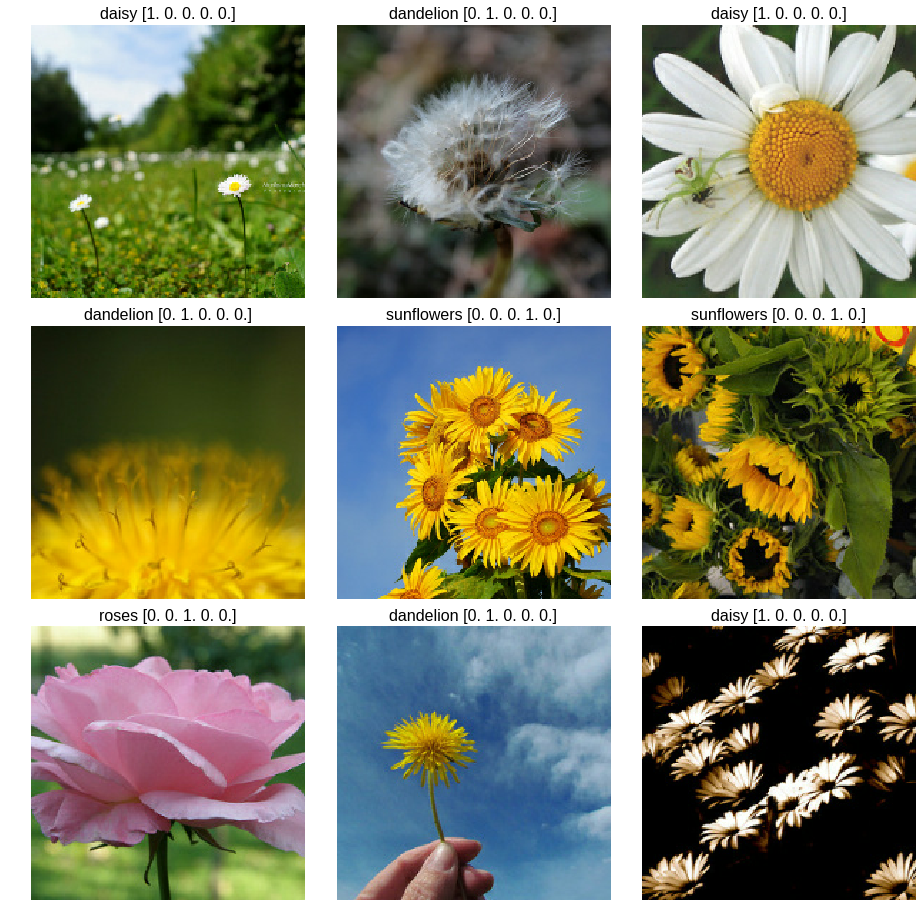

In [0]:
display_9_images_from_dataset(load_dataset(training_filenames))

## training and validation datasets

In [0]:
def features_and_targets(image, label, one_hot_label):
  feature = image
  target = one_hot_label
  return feature, target  # for training, a Keras model needs 2 items: features and targets

def get_batched_dataset(filenames):
  dataset = load_dataset(filenames)
  dataset = dataset.map(features_and_targets, num_parallel_calls=32)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drop_remainder needed on TPU
  dataset = dataset.prefetch(-1) # prefetch next batch while training (-1: autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset

# input functions
def training_input_fn():
  return get_batched_dataset(training_filenames)
def validation_input_fn():
  return get_batched_dataset(validation_filenames)

## Model

In [0]:
def model_fn(features, labels, mode, params):
  module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_050_192/feature_vector/2")
  #module = hub.Module("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/1")
  
  transformed_features = module(features)
  logits = tf.layers.dense(transformed_features, 5)
  probabilities = tf.nn.softmax(logits)
  
  if (mode != tf.estimator.ModeKeys.PREDICT):
    loss = tf.losses.softmax_cross_entropy(labels, logits)
    optimizer = tf.train.AdamOptimizer() 
    train_op = tf.contrib.training.create_train_op(loss, optimizer)
    accuracy = tf.metrics.accuracy(tf.argmax(labels, axis=-1), tf.argmax(probabilities, axis=-1))
    metrics = {'acc':accuracy}
  else:
    # None of these can be computed in prediction mode because labels are not available
    loss = optimizer = train_op = metrics = None
  
  return tf.estimator.EstimatorSpec(
      mode=mode,
      loss=loss,
      train_op=train_op,
      # Nice: in estimator, you can return computed results that are not part of model training (here: class)
      predictions={'proba': probabilities, 'class': tf.argmax(probabilities, axis=-1)},
      eval_metric_ops=metrics
  )

In [0]:
!rm -rf ./model_dir

In [0]:
training_config = tf.estimator.RunConfig(model_dir="./model_dir", save_summary_steps=5, save_checkpoints_steps=steps_per_epoch, log_step_count_steps=5)
estimator = tf.estimator.Estimator(model_fn=model_fn, config=training_config)
train_spec = tf.estimator.TrainSpec(training_input_fn, max_steps=EPOCHS*steps_per_epoch)
eval_spec = tf.estimator.EvalSpec(validation_input_fn, steps=validation_steps, throttle_secs=1)
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Using config: {'_model_dir': './model_dir', '_tf_random_seed': None, '_save_summary_steps': 5, '_save_checkpoints_steps': 46, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f00f68aada0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will

({'acc': 0.8953125, 'global_step': 276, 'loss': 0.30796465}, [])

## Predictions

In [0]:
N=9
# random input: execute multiple times to change results
numpy_flowers, numpy_labels, _ = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), N)

# tip: this is how to get create dataset from a numpy array
def predict_input_fn():
  return tf.data.Dataset.from_tensor_slices(numpy_flowers).batch(N)

predictions = estimator.predict(predict_input_fn)  # estimator.predict returns a Python generator
                                                   # you can iterate on it to get individual predictions

probabilities = []
for p in predictions:
  print(p['class'])  # as defined in EstimatorSpec.predictions
  print(p['proba'])
  probabilities.append(p['proba'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model_dir/model.ckpt-276
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0
[0.8113111  0.06538754 0.001103   0.02989177 0.09230649]
0
[0.6201507  0.21773808 0.0012906  0.15982513 0.0009955 ]
1
[4.1748318e-03 9.8975825e-01 2.5657110e-03 3.0184304e-03 4.8285263e-04]
2
[2.5280069e-05 9.1626254e-07 9.9952590e-01 3.0841395e-06 4.4480362e-04]
4
[0.00263572 0.01357154 0.1434204  0.05015709 0.79021525]
3
[1.0049560e-02 5.3095922e-04 1.6704817e-05 9.8924410e-01 1.5864738e-04]
2
[0.19284558 0.15277316 0.38096863 0.03972606 0.23368657]
4
[2.5759968e-03 2.7964351e-04 2.0073120e-02 5.2250567e-04 9.7654867e-01]
4
[0.13671833 0.09005722 0.3016917  0.00263377 0.4688989 ]


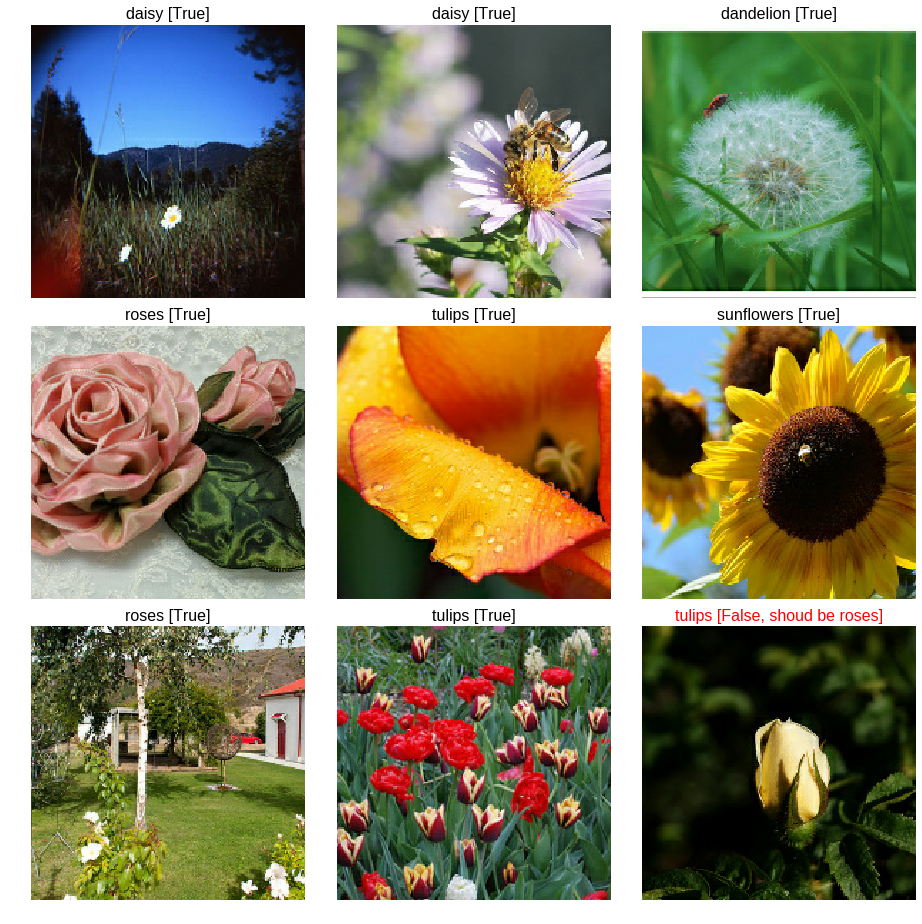

In [0]:
display_9_images_with_predictions(numpy_flowers, probabilities, numpy_labels)